In [2]:
import pandas as pd
import datetime
from ipywidgets import *
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 60)

In [3]:
"""
-- Modified original query from https://dune.com/queries/92408/184718

SELECT 
  tx.hash,
  tx.success,
  --pid."name", 
  mints."_projectId" AS ProjectID,
  tx.value/1e18 AS price_eth,
  date_trunc('second', mints."evt_block_time") AS time,   
  mints."_to" AS buyer, 
  (tx."gas_used" * tx."gas_price"/1e18) AS gas_eth
FROM artblocks."GenArt721_evt_Mint" mints -- old contrct
LEFT JOIN ethereum.transactions tx
  ON mints."evt_tx_hash" = tx."hash"
--LEFT JOIN dune_user_generated.ArtBlocksProjectIDs pid 
--  ON pid.id = mints."_projectId"

UNION ALL 
    
SELECT 
  tx.hash,
  tx.success,
  --pid."name", 
  mints."_projectId" AS ProjectID, 
  tx.value/1e18 AS price, 
  date_trunc('second', mints."call_block_time") AS time, 
  mints."_by" AS buyer, 
  (tx."gas_used" * tx."gas_price"/1e18) AS gas_eth
FROM artblocks."GenArt721Core_call_mint" mints -- new contract
LEFT JOIN ethereum.transactions tx
  ON mints."call_tx_hash" = tx."hash"
--LEFT JOIN dune_user_generated.ArtBlocksProjectIDs pid 
--  ON pid.id = mints."_projectId"
WHERE "output__tokenId" is not null
ORDER BY time DESC
"""

d = pd.read_csv('../mint.csv')
d["time"] = pd.to_datetime(d["time"])
display(d.dtypes)

# sort by time and descending gas for most probable execution order without looking at transaction order numbers.
d.sort_values(by=["time", "gas_eth"], ascending=[True, False], inplace=True)

d.head()

hash                      object
success                     bool
projectid                  int64
price_eth                float64
time         datetime64[ns, UTC]
buyer                     object
gas_eth                  float64
dtype: object

,hash,success,projectid,price_eth,time,buyer,gas_eth
204059,\xc86f9caf0307f66d63c03aa1952f47e1a7f09243a8e7e3b26faa374a60c253dc,True,2,0.10,2020-11-27 15:58:01+00:00,\x7d42611012fdbe366bf4a0481fc0e1abf15e245a,0.015308
204058,\x2b4c7709bcb24f5f0337fcf5c045a5cbc911ab118f8bd0439db52615aa12d2ad,True,2,0.10,2020-11-27 16:00:31+00:00,\x7d42611012fdbe366bf4a0481fc0e1abf15e245a,0.013010
204057,\x99666b7a136f58b78abbb8226bae746e51293c927d2efc8d3d2e4bb4f3c1f500,True,2,0.10,2020-11-27 16:08:37+00:00,\x7d42611012fdbe366bf4a0481fc0e1abf15e245a,0.015034
204056,\x148da1d93e382e3220df987557f0240f14e24772feb4435a7a0337d607da6cdf,True,1,0.05,2020-11-27 16:10:41+00:00,\xc7391970d642faf65fabac8f63b0d41c4481d787,0.017108
204055,\x9e812dec2467b3f9c84fc3e589cc608360284a51def0bcae675fd43bae4da26f,True,2,0.10,2020-11-27 16:11:28+00:00,\xc7391970d642faf65fabac8f63b0d41c4481d787,0.014986


In [4]:
display(d.info())
display("Number of successful mints: ", d.success.sum())
d.describe(include=['bool','float', 'int', 'datetime'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204060 entries, 204059 to 0
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   hash       204060 non-null  object             
 1   success    204060 non-null  bool               
 2   projectid  204060 non-null  int64              
 3   price_eth  204060 non-null  float64            
 4   time       204060 non-null  datetime64[ns, UTC]
 5   buyer      204060 non-null  object             
 6   gas_eth    204060 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(2), int64(1), object(2)
memory usage: 11.1+ MB


None

'Number of successful mints: '

198604

,success,projectid,price_eth,gas_eth
count,204060,204060.000000,204060.000000,204060.000000
unique,2,NaN,NaN,NaN
top,True,NaN,NaN,NaN
freq,198604,NaN,NaN,NaN
mean,NaN,152.841855,0.460313,0.074256
std,NaN,98.342955,0.942731,0.142770
min,NaN,0.000000,0.000000,0.000000
25%,NaN,74.000000,0.100000,0.016525
50%,NaN,143.000000,0.120000,0.038102
75%,NaN,227.000000,0.287963,0.074728


In [5]:
mints = d[d["success"]]

import statistics

def getMiddleValue(pdSeries):
    mid = (pdSeries.count() / 2).astype(int)
    return pdSeries.iloc[mid]

mintsByProjectId = mints.groupby("projectid")
mintsByProjectId = pd.DataFrame({
    "count": mintsByProjectId["projectid"].count(),
    "firstMintTime": mintsByProjectId["time"].first(),
    "lastMintTime": mintsByProjectId["time"].last(),
    "lastMintPriceTotal": mintsByProjectId["price_eth"].last() + mintsByProjectId["gas_eth"].last(),
    "minMintPrice": mintsByProjectId["price_eth"].min(),
	"medianMintPrice": mintsByProjectId["price_eth"].median(),
	"meanMintPrice": mintsByProjectId["price_eth"].mean(),
    "medianMintTime":  mintsByProjectId["time"].apply(lambda x: getMiddleValue(x))
    })
mintsByProjectId["latterMintWindowInMins"] = round((mintsByProjectId["lastMintTime"] - mintsByProjectId["medianMintTime"]).dt.total_seconds() / 60, 2)
mintsByProjectId["totalMintWindowInMins"] = ((mintsByProjectId["lastMintTime"] - mintsByProjectId["firstMintTime"]).dt.total_seconds() / 60)
mintsByProjectId["mintWindowUnder4Hours"] = (mintsByProjectId["totalMintWindowInMins"] <= 240)

In [6]:
firstMints = mints.groupby("projectid")
firstMints = firstMints["time"].first()
# getting first mint timestamp on every mint of the same collection
firstMintForEach = pd.merge(mints, firstMints, on="projectid", how="outer")
firstMintForEach["time_x"] = pd.to_datetime(firstMintForEach["time_x"])
firstMintForEach["time_y"] = pd.to_datetime(firstMintForEach["time_y"])
# creating the boolean to know if the collections match the setting
firstMintForEach["secondMintWithin12Hours"] = ((firstMintForEach["time_x"] - firstMintForEach["time_y"]).dt.total_seconds() / 3600 < 12)
groupedFirstMintForEach = firstMintForEach.groupby("projectid").sum()

     projectid             firstMintTime              lastMintTime  mintWindow
0            7 2020-12-21 19:00:36+00:00 2020-12-21 19:08:11+00:00    0.126389
1            9 2021-01-08 18:08:41+00:00 2021-01-08 18:17:08+00:00    0.140833
2           11 2021-01-21 20:15:57+00:00 2021-01-21 20:32:47+00:00    0.280556
3           12 2021-01-26 23:00:31+00:00 2021-01-26 23:03:23+00:00    0.047778
4           13 2021-01-31 17:59:27+00:00 2021-01-31 18:19:04+00:00    0.326944
..         ...                       ...                       ...         ...
277        337 2022-08-10 17:15:24+00:00 2022-08-10 17:46:40+00:00    0.521111
278        338 2022-08-03 17:00:44+00:00 2022-08-03 17:17:51+00:00    0.285278
279        339 2022-07-31 16:58:40+00:00 2022-08-01 17:16:07+00:00   24.290833
280        340 2022-08-08 17:16:16+00:00 2022-08-08 17:19:29+00:00    0.053611
281        343 2022-08-12 17:22:58+00:00 2022-08-12 17:34:32+00:00    0.192778

[174 rows x 4 columns]


<AxesSubplot:title={'center':'mint window after filtering'}, xlabel='projectid', ylabel='mintWindow(hours)'>

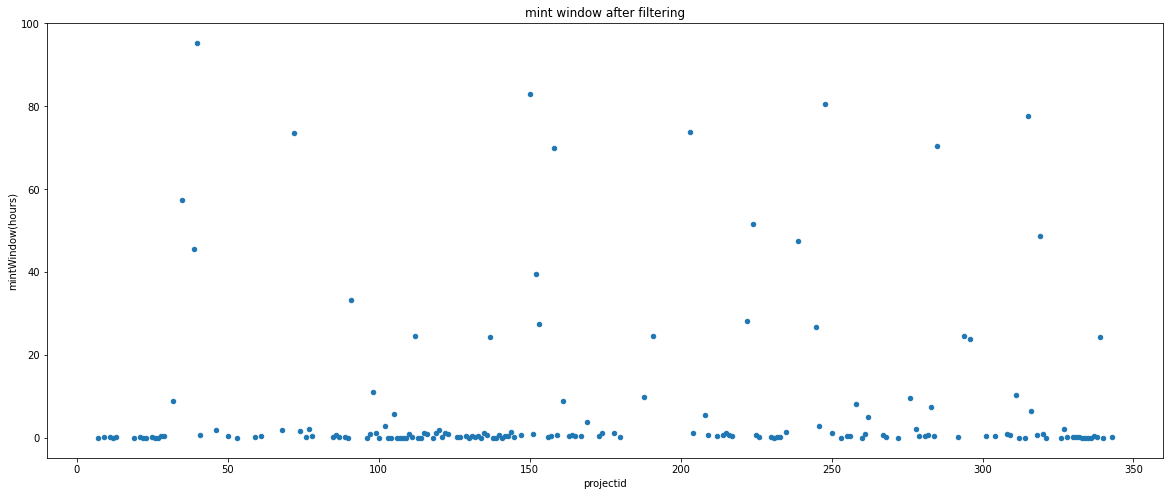

In [7]:
earlyMintsIds = groupedFirstMintForEach[groupedFirstMintForEach["secondMintWithin12Hours"] < 2]
mintsWithEarlyMintsIds = pd.merge(earlyMintsIds, mints, on="projectid", how="outer")
# getting a dataset with every mints from matching collections
mintsWithEarlyMintsIds = mintsWithEarlyMintsIds[mintsWithEarlyMintsIds["secondMintWithin12Hours"] < 2]
groupedEarlyMintsProjects = mintsWithEarlyMintsIds.groupby("projectid")
# removing first mint
groupedEarlyMintsProjects = groupedEarlyMintsProjects["time"].first()
mintsWithEarlyMintsIds = pd.merge(groupedEarlyMintsProjects, mintsWithEarlyMintsIds, on="projectid", how="outer")
mintsWithEarlyMintsIds = mintsWithEarlyMintsIds[mintsWithEarlyMintsIds["time_x"] != mintsWithEarlyMintsIds["time_y"]]
groupedMintsWithEarlyMintsIds = mintsWithEarlyMintsIds.groupby("projectid")
#creating mint window dataset
mintsWithEarlyMintsIds = pd.DataFrame({
    "firstMintTime": groupedMintsWithEarlyMintsIds["time_y"].first(),
    "lastMintTime": groupedMintsWithEarlyMintsIds["time_y"].last()
})
mintsWithEarlyMintsIds["firstMintTime"] = pd.to_datetime(mintsWithEarlyMintsIds["firstMintTime"])
mintsWithEarlyMintsIds["lastMintTime"] = pd.to_datetime(mintsWithEarlyMintsIds["lastMintTime"])
mintsWithEarlyMintsIds["mintWindow"] = ((mintsWithEarlyMintsIds["lastMintTime"] - mintsWithEarlyMintsIds["firstMintTime"]).dt.total_seconds() / 3600)
mintsWithEarlyMintsIds = mintsWithEarlyMintsIds.reset_index()
# filtering the dataset and rendering the analysis
mintsWithEarlyMintsIds = mintsWithEarlyMintsIds[mintsWithEarlyMintsIds["mintWindow"] < 100]
print(mintsWithEarlyMintsIds)
mintsWithEarlyMintsIds.plot.scatter(x="projectid", y="mintWindow", figsize=(20,8), ylabel="mintWindow(hours)", title="mint window after filtering")

In [8]:
mintsByProjectIdNoIndex = mintsByProjectId.reset_index()
settings = ["medianMintPrice", "meanMintPrice", "minMintPrice", "totalMintWindowInMins"]
def updateStats(i = 1):
	mintsByProjectIdNoIndex.plot.scatter(x="projectid", y=settings[i], figsize=(20,8), title="all collections")
	mintsByProjectIdNoIndex[mintsByProjectIdNoIndex["mintWindowUnder4Hours"] == True].plot.scatter(x="projectid", y=settings[i], figsize=(20,8), title="sold out under 4 hours")

interact(updateStats)

interactive(children=(IntSlider(value=1, description='i', max=3, min=-1), Output()), _dom_classes=('widget-int…

<function __main__.updateStats(i=1)>

In [9]:
"""
-- Modified original query from https://dune.com/queries/160701/314169

select distinct block_time, 
  ROUND("nft_token_id"::numeric / 1000000) as projectid,
  round(eth_amount, 2) as eth_price, 
  usd_price, 
  link, 
  platform, 
  left(seller::text, 7) as seller, 
  left(buyer::text, 7) as buyer 
from 
(
select 
  block_time, 
  platform, 
  usd_amount, 
     
  case 
     when ("original_currency" = 'ETH' OR "original_currency" = 'WETH')
             THEN  ("original_amount")
    else 0  
  END as eth_amount, 
  "usd_amount" as usd_price,

   
 CONCAT('<a href="https://opensea.io/assets/', CONCAT('0x', substring(a."nft_contract_address"::text from 3)), '/', a.nft_token_id,  '/?ref=0x8F903cFC0Af3C2EC0d872c57538AF5e071544a57','" target="_blank" >', 'View on OS', '</a>') as  link,
   
 seller, 
 buyer, 
 tx_hash,
 nft_token_id

from nft."trades" a
WHERE 
     "trade_type" = 'Single Item Trade'
     AND (a.nft_contract_address = '\xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270'
    OR  a.nft_contract_address = '\x059edd72cd353df5106d2b9cc5ab83a52287ac3a')
ORDER BY block_time DESC 
) gg
-- WHERE block_time > '{{Date}}'
order by block_time DESC
"""

p = pd.read_csv('../sales.csv')

display("Before filtering:", len(d))

# cleaning up weird project ids
p_removed = p[p["projectid"].str.len() >= 8]
p = p[p["projectid"].str.len() < 8]

# casting
p["block_time"] = pd.to_datetime(p["block_time"])
p["projectid"] = p["projectid"].astype(int)

p.sort_values(by=["block_time"], ascending=[True], inplace=True)


# adding derived data
p["normalized_price"] = p["eth_price"] / p["projectid"].map(mintsByProjectId.lastMintPriceTotal)
p["lastMintTime"] = p["projectid"].map(mintsByProjectId.lastMintTime)
p["isWithin2hFromLastMintTime"] = ((p["block_time"] - p["lastMintTime"]).dt.total_seconds() / 60 < 120) & ((p["block_time"] - p["lastMintTime"]).dt.total_seconds() > 0)

display(p.dtypes)
display(p.describe(include=['bool','float', 'int', 'datetime']))
p

/home/user42/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


'Before filtering:'

204060

block_time                    datetime64[ns, UTC]
projectid                                   int64
eth_price                                 float64
usd_price                                 float64
link                                       object
platform                                   object
seller                                     object
buyer                                      object
normalized_price                          float64
lastMintTime                  datetime64[ns, UTC]
isWithin2hFromLastMintTime                   bool
dtype: object

,projectid,eth_price,usd_price,normalized_price,isWithin2hFromLastMintTime
count,43833.000000,43833.00000,4.376100e+04,43833.000000,43833
unique,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,35300
mean,204.691146,1.57886,4.685512e+03,5.266007,NaN
std,84.607758,5.71663,1.843462e+04,36.838401,NaN
min,0.000000,0.00000,0.000000e+00,0.000000,NaN
25%,157.000000,0.17000,4.031410e+02,0.559423,NaN
50%,215.000000,0.48000,1.281197e+03,1.147914,NaN
75%,253.000000,1.40000,4.044180e+03,1.953432,NaN


,block_time,projectid,eth_price,usd_price,link,platform,seller,buyer,normalized_price,lastMintTime,isWithin2hFromLastMintTime
65535,2021-10-31 16:20:04+00:00,188,0.75,3145.33500,"<a href=""https://opensea.io/assets/0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270/188000723/?ref=0x8F903cFC0Af3C2EC0d872c57538AF...",OpenSea,\x81a4a,\xa5430,2.912741,2021-10-30 04:51:27+00:00,False
65534,2021-10-31 16:45:39+00:00,156,0.09,380.65320,"<a href=""https://opensea.io/assets/0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270/156000101/?ref=0x8F903cFC0Af3C2EC0d872c57538AF...",OpenSea,\x5b873,\xe0d66,0.403696,2021-09-14 19:10:49+00:00,False
65533,2021-10-31 16:52:02+00:00,182,0.10,421.89500,"<a href=""https://opensea.io/assets/0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270/182000089/?ref=0x8F903cFC0Af3C2EC0d872c57538AF...",OpenSea,\xc7cf7,\xe0d66,0.969415,2022-08-08 00:10:44+00:00,False
65532,2021-10-31 17:06:48+00:00,188,0.35,1485.52600,"<a href=""https://opensea.io/assets/0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270/188000612/?ref=0x8F903cFC0Af3C2EC0d872c57538AF...",OpenSea,\xbb5bc,\xf6a6e,1.359279,2021-10-30 04:51:27+00:00,False
65531,2021-10-31 17:09:44+00:00,153,0.12,492.34576,"<a href=""https://opensea.io/assets/0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270/153000392/?ref=0x8F903cFC0Af3C2EC0d872c57538AF...",OpenSea,\xb6d6b,\xa05f7,0.396312,2021-10-02 20:05:29+00:00,False
...,...,...,...,...,...,...,...,...,...,...,...
4,2022-08-13 06:51:34+00:00,116,0.06,110.28435,"<a href=""https://opensea.io/assets/0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270/116003757/?ref=0x8F903cFC0Af3C2EC0d872c57538AF...",OpenSea,\x62161,\x99500,0.355814,2021-08-02 17:06:52+00:00,False
3,2022-08-13 06:53:41+00:00,242,0.13,252.65142,"<a href=""https://opensea.io/assets/0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270/242000228/?ref=0x8F903cFC0Af3C2EC0d872c57538AF...",OpenSea,\x6c7f5,\x5c46a,0.885286,2022-07-05 00:40:04+00:00,False
2,2022-08-13 06:56:04+00:00,337,0.19,376.62040,"<a href=""https://opensea.io/assets/0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270/337000497/?ref=0x8F903cFC0Af3C2EC0d872c57538AF...",OpenSea,\x3615e,\x457ee,0.319588,2022-08-10 17:46:40+00:00,False
1,2022-08-13 06:57:34+00:00,116,0.07,140.23100,"<a href=""https://opensea.io/assets/0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270/116003379/?ref=0x8F903cFC0Af3C2EC0d872c57538AF...",OpenSea,\xed595,\x99500,0.415117,2021-08-02 17:06:52+00:00,False


In [10]:
tradesByProjectId = p.groupby("projectid")
tradesByProjectId = pd.DataFrame({
    "tradeCount": tradesByProjectId["projectid"].count(),
    "tradeCount2hr": tradesByProjectId["isWithin2hFromLastMintTime"].sum(),
    "medianNormPrice2h": tradesByProjectId.apply(lambda df: df[df["isWithin2hFromLastMintTime"]].normalized_price.median()),
})

In [11]:
byProjectId = pd.merge(mintsByProjectId, tradesByProjectId, on="projectid", how="outer")
byProjectId

,count,firstMintTime,lastMintTime,lastMintPriceTotal,minMintPrice,medianMintPrice,meanMintPrice,medianMintTime,latterMintWindowInMins,totalMintWindowInMins,mintWindowUnder4Hours,tradeCount,tradeCount2hr,medianNormPrice2h
projectid,,,,,,,,,,,,,,
0,9675,2020-11-27 16:12:02+00:00,2022-07-01 21:37:25+00:00,0.389623,0.000,0.035000,0.033245,2020-12-27 05:20:22+00:00,794417.05,836965.383333,False,1317.0,4.0,34.648851
1,512,2020-11-27 16:10:41+00:00,2020-11-27 20:30:05+00:00,0.056052,0.050,0.050000,0.050000,2020-11-27 18:59:36+00:00,90.48,259.400000,False,46.0,0.0,NaN
2,500,2020-11-27 15:58:01+00:00,2020-11-27 18:26:48+00:00,0.111816,0.100,0.100000,0.100200,2020-11-27 17:40:32+00:00,46.27,148.783333,True,57.0,0.0,NaN
3,1921,2020-12-12 16:30:17+00:00,2021-02-23 22:12:31+00:00,0.066522,0.000,0.000000,0.011630,2021-02-07 05:41:02+00:00,24031.48,105462.233333,False,145.0,0.0,NaN
4,512,2020-12-12 13:31:24+00:00,2020-12-12 20:17:48+00:00,0.059003,0.050,0.050000,0.050000,2020-12-12 20:08:09+00:00,9.65,406.400000,False,39.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,1,2022-07-29 16:50:57+00:00,2022-07-29 16:50:57+00:00,0.212582,0.200,0.200000,0.200000,2022-07-29 16:50:57+00:00,0.00,0.000000,True,NaN,NaN,NaN
343,200,2022-07-29 14:18:42+00:00,2022-08-12 17:34:32+00:00,0.107103,0.100,0.102464,0.106126,2022-08-12 17:33:00+00:00,1.53,20355.833333,False,127.0,115.0,1.400517
344,10,2022-08-03 20:46:05+00:00,2022-08-09 13:02:30+00:00,0.203701,0.200,0.200000,0.200000,2022-08-03 21:09:07+00:00,8153.38,8176.416667,False,NaN,NaN,NaN


In [12]:
def update(projectid = 331):
    pId = p[p["projectid"] == projectid]
    pId[pId["isWithin2hFromLastMintTime"]].plot(x="block_time", y=["normalized_price", "eth_price"], figsize=(20,8))

interact(update)

interactive(children=(IntSlider(value=331, description='projectid', max=993, min=-331), Output()), _dom_classe…

<function __main__.update(projectid=331)>

In [13]:
view = mints[mints["projectid"] == 337]